# <span style="color:#91299A">Расчёты для главы 2 диплома - плоско-параллельного движения</span> 

![](../storage/banners/11_planar_motion.png)

In [332]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import seaborn as sns
from sympy import *
from p_tqdm import p_map
import pandas as pd

Radius_orbit=7e6
mu=398576057600000.06
w_hkw = np.sqrt(mu / (Radius_orbit ** 3))

##### <span style="color:#8e9092">Регулировка отображения</span> 

In [ ]:
#SMALL_SIZE = 12
#MEDIUM_SIZE = 14
#BIGGER_SIZE = 16
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

##### <span style="color:#8e9092">Введение параметров</span> 

In [42]:
m_ub, m_ss, J_y, Jp_y, T, w_0, phi_0 = var('m_ub m_ss J_y Jp_y T w_0 phi_0', real=True, constant=True)

# Начальные параметры UB ORF
x_ub_orf_p, z_ub_orf_p, vx_ub_orf_p, vz_ub_orf_p, wp_y = var('x_ub_orf_p z_ub_orf_p vx_ub_orf_p vz_ub_orf_p wp_y', real=True, constant=True)
# Начальные параметры UB SRF
x_ub_srf_p, z_ub_srf_p, x_ub_srf_a, z_ub_srf_a = var('x_ub_srf_p z_ub_srf_p x_ub_srf_a z_ub_srf_a', real=True, constant=True)
# Начальные параметры SS SRF, целевой точки
x_ss_srf_p, z_ss_srf_p, x_ss_srf_a, z_ss_srf_a, x_target_srf, z_target_srf = var('x_ss_srf_p z_ss_srf_p x_ss_srf_a z_ss_srf_a x_target_srf z_target_srf', real=True, constant=True)

# Параметры отталкивания
v0_x, v0_z, t = var('v0_x v0_z t', real=True)
# Конечные положения в момент времени T
x_ub_orf_f, z_ub_orf_f, vx_ub_orf_f, vz_ub_orf_f, x_ss_orf_f, z_ss_orf_f, vx_ss_orf_f, vz_ss_orf_f, phi = symbols('x_ub_orf_f z_ub_orf_f vx_ub_orf_f vz_ub_orf_f x_ss_orf_f z_ss_orf_f vx_ss_orf_f vz_ss_orf_f phi', cls=Function)

"x_ub_orf_f = Function('x_ub_orf_f')\nz_ub_orf_f = Function('z_ub_orf_f')\nvx_ub_orf_f = Function('vx_ub_orf_f')\nvz_ub_orf_f = Function('vz_ub_orf_f')\nx_ss_orf_f = Function('x_ss_orf_f')\nz_ss_orf_f = Function('z_ss_orf_f')\nvx_ss_orf_f = Function('vx_ss_orf_f')\nvz_ss_orf_f = Function('vz_ss_orf_f')\nphi = Function('phi')"

### <span style="color:#A254FC">Рассчёт с нуля (не включать без необходимости)</span> 

In [322]:
# Вращательное движение
S = Matrix([[cos(phi_0), 0, -sin(phi_0)],
            [0,        1,         0],
            [sin(phi_0), 0,  cos(phi_0)]])
U = Matrix([[-sin(w_0*t), cos(w_0*t), 0],
            [0,           0,          1],
            [cos(w_0*t),  sin(w_0*t), 0]])
A = S @ U

wp_orf = Matrix([0, wp_y, 0])
wp_irf = U.T @ wp_orf

# Поступательное движение
v_ub_orf_p = Matrix([vx_ub_orf_p, 0, vz_ub_orf_p])

r_ub_srf_p = Matrix([x_ub_srf_p, 0, z_ub_srf_p])
r_ub_srf_a = Matrix([x_ub_srf_a, 0, z_ub_srf_a])
r_ub_orf_p = Matrix([x_ub_orf_p, 0, z_ub_orf_p])
r_ub_orf_a = r_ub_orf_p + S.T @ (r_ub_srf_a - r_ub_srf_p)

r_ss_srf_p = Matrix([x_ss_srf_p, 0, z_ss_srf_p])
r_ss_srf_a = Matrix([x_ss_srf_a, 0, z_ss_srf_a])  # Вот тут я сомневаюсь, что у нас есть информация
r_ss_orf_p = r_ub_orf_p + S.T @ (r_ss_srf_p - r_ub_srf_p)
r_ss_orf_a = r_ub_orf_p + S.T @ (r_ss_srf_a - r_ub_srf_p)

v0 = Matrix([v0_x, 0, v0_z])
Dv_ss_orf_a = S.T @ v0
Dv_ub_orf_a = -m_ss/m_ub * Dv_ss_orf_a

v_ub_orf_a = v_ub_orf_p + wp_orf.cross(r_ub_orf_a - r_ub_orf_p) + Dv_ub_orf_a
v_ss_orf_a = v_ub_orf_p + wp_orf.cross(r_ss_orf_a - r_ss_orf_p) + Dv_ss_orf_a

w = (Jp_y*wp_orf + (m_ss+m_ub)*r_ub_orf_p.cross(v_ub_orf_p) - m_ss*r_ss_orf_a.cross(v_ss_orf_a) - m_ub*r_ub_orf_a.cross(v_ub_orf_a) ) / J_y
w_y = w[1]

# Рассчёт параметров после отталкивания
eqs = [Eq(phi(t).diff(t), w_y), 
       Eq(x_ub_orf_f(t).diff(t), vx_ub_orf_f(t)), 
       Eq(z_ub_orf_f(t).diff(t), vz_ub_orf_f(t)),
       Eq(vx_ub_orf_f(t).diff(t), -2*w_0*vz_ub_orf_f(t)), 
       Eq(vz_ub_orf_f(t).diff(t), 3*w_0**2*z_ub_orf_f(t) + 2*w_0*vx_ub_orf_f(t)), 
       Eq(x_ss_orf_f(t).diff(t), vx_ss_orf_f(t)), 
       Eq(z_ss_orf_f(t).diff(t), vz_ss_orf_f(t)),
       Eq(vx_ss_orf_f(t).diff(t), -2*w_0*vz_ss_orf_f(t)), 
       Eq(vz_ss_orf_f(t).diff(t), 3*w_0**2*z_ss_orf_f(t) + 2*w_0*vx_ss_orf_f(t))]

initium = dsolve(eq=eqs, func=[x_ub_orf_f(t), z_ub_orf_f(t), vx_ub_orf_f(t), vz_ub_orf_f(t), 
                               x_ss_orf_f(t), z_ss_orf_f(t), vx_ss_orf_f(t), vz_ss_orf_f(t), phi(t)],
                 ics={x_ub_orf_f(0): r_ub_orf_a[0], z_ub_orf_f(0): r_ub_orf_a[2], 
                      x_ss_orf_f(0): r_ss_orf_a[0], z_ss_orf_f(0): r_ss_orf_a[2],
                      vx_ub_orf_f(0): v_ub_orf_a[0], vz_ub_orf_f(0): v_ub_orf_a[2], 
                      vx_ss_orf_f(0): v_ss_orf_a[0], vz_ss_orf_f(0): v_ss_orf_a[2], phi(0): phi_0})

# Проверка на вшивость
print(int(initium[0].rhs.diff(t) - initium[2].rhs) == 0)

x_ub_orf_anw = initium[0].rhs
z_ub_orf_anw = initium[1].rhs
vx_ub_orf_anw = initium[2].rhs
vz_ub_orf_anw = initium[3].rhs
x_ss_orf_anw = initium[4].rhs
z_ss_orf_anw = initium[5].rhs
vx_ss_orf_anw = initium[6].rhs
vz_ss_orf_anw = initium[7].rhs
phi_anw = initium[8].rhs

True


### <span style="color:#A254FC">Краткая запись параметров</span> 

In [ ]:
x_ub_orf_anw = 3*t*(m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(vx_ub_orf_p + 2*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))/m_ub + 2*(m_ss*(v0_x*sin(phi_0) - v0_z*cos(phi_0)) + m_ub*(vz_ub_orf_p - wp_y*(x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0))))*cos(t*w_0)/(m_ub*w_0) - (2*m_ss*(v0_x*sin(phi_0) - v0_z*cos(phi_0)) - m_ub*(-2*vz_ub_orf_p + w_0*(x_ub_orf_p + x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0)) + 2*wp_y*(x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0))))/(m_ub*w_0) - 2*(2*m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(2*vx_ub_orf_p + 3*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))*sin(t*w_0)/(m_ub*w_0)
z_ub_orf_anw = (m_ss*(v0_x*sin(phi_0) - v0_z*cos(phi_0)) + m_ub*(vz_ub_orf_p - wp_y*(x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0))))*sin(t*w_0)/(m_ub*w_0) - 2*(m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(vx_ub_orf_p + 2*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))/(m_ub*w_0) + (2*m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(2*vx_ub_orf_p + 3*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))*cos(t*w_0)/(m_ub*w_0)
vx_ub_orf_anw = -2*(m_ss*(v0_x*sin(phi_0) - v0_z*cos(phi_0)) + m_ub*(vz_ub_orf_p - wp_y*(x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0))))*sin(t*w_0)/m_ub + 3*(m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(vx_ub_orf_p + 2*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))/m_ub - 2*(2*m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(2*vx_ub_orf_p + 3*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))*cos(t*w_0)/m_ub
vz_ub_orf_anw = (m_ss*(v0_x*sin(phi_0) - v0_z*cos(phi_0)) + m_ub*(vz_ub_orf_p - wp_y*(x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0))))*cos(t*w_0)/m_ub - (2*m_ss*(v0_x*cos(phi_0) + v0_z*sin(phi_0)) - m_ub*(2*vx_ub_orf_p + 3*w_0*(-x_ub_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ub_orf_p + z_ub_srf_a*cos(phi_0) - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0))))*sin(t*w_0)/m_ub
x_ss_orf_anw = -3*t*(v0_x*cos(phi_0) + v0_z*sin(phi_0) + vx_ub_orf_p + 2*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) - wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0))) - 2*(v0_x*sin(phi_0) - v0_z*cos(phi_0) - vz_ub_orf_p + wp_y*(x_ss_srf_a*cos(phi_0) - x_ss_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ss_srf_p*sin(phi_0)))*cos(t*w_0)/w_0 + (2*v0_x*sin(phi_0) - 2*v0_z*cos(phi_0) - 2*vz_ub_orf_p + w_0*(x_ss_srf_a*cos(phi_0) + x_ub_orf_p - x_ub_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0)) + 2*wp_y*(x_ss_srf_a*cos(phi_0) - x_ss_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ss_srf_p*sin(phi_0)))/w_0 + 2*(2*v0_x*cos(phi_0) + 2*v0_z*sin(phi_0) + 2*vx_ub_orf_p + 3*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0)))*sin(t*w_0)/w_0
z_ss_orf_anw = -(v0_x*sin(phi_0) - v0_z*cos(phi_0) - vz_ub_orf_p + wp_y*(x_ss_srf_a*cos(phi_0) - x_ss_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ss_srf_p*sin(phi_0)))*sin(t*w_0)/w_0 + 2*(v0_x*cos(phi_0) + v0_z*sin(phi_0) + vx_ub_orf_p + 2*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) - wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0)))/w_0 - (2*v0_x*cos(phi_0) + 2*v0_z*sin(phi_0) + 2*vx_ub_orf_p + 3*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0)))*cos(t*w_0)/w_0
vx_ss_orf_anw = -3*v0_x*cos(phi_0) - 3*v0_z*sin(phi_0) - 3*vx_ub_orf_p - 6*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) + 3*wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0)) + 2*(v0_x*sin(phi_0) - v0_z*cos(phi_0) - vz_ub_orf_p + wp_y*(x_ss_srf_a*cos(phi_0) - x_ss_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ss_srf_p*sin(phi_0)))*sin(t*w_0) + 2*(2*v0_x*cos(phi_0) + 2*v0_z*sin(phi_0) + 2*vx_ub_orf_p + 3*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0)))*cos(t*w_0)
vz_ss_orf_anw = -(v0_x*sin(phi_0) - v0_z*cos(phi_0) - vz_ub_orf_p + wp_y*(x_ss_srf_a*cos(phi_0) - x_ss_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ss_srf_p*sin(phi_0)))*cos(t*w_0) + (2*v0_x*cos(phi_0) + 2*v0_z*sin(phi_0) + 2*vx_ub_orf_p + 3*w_0*(-x_ss_srf_a*sin(phi_0) + x_ub_srf_p*sin(phi_0) + z_ss_srf_a*cos(phi_0) + z_ub_orf_p - z_ub_srf_p*cos(phi_0)) - 2*wp_y*(x_ss_srf_a*sin(phi_0) - x_ss_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ss_srf_p*cos(phi_0)))*sin(t*w_0)
phi_anw = phi_0 + t*(Jp_y*wp_y + m_ss*(-v0_x*(z_ss_srf_a*sin(phi_0)**2 + z_ss_srf_a*cos(phi_0)**2 - z_ub_srf_a*sin(phi_0)**2 - z_ub_srf_a*cos(phi_0)**2) + v0_z*(x_ss_srf_a*sin(phi_0)**2 + x_ss_srf_a*cos(phi_0)**2 - x_ub_srf_a*sin(phi_0)**2 - x_ub_srf_a*cos(phi_0)**2) + vx_ub_orf_p*(x_ss_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ss_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0)) + vz_ub_orf_p*(x_ss_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ss_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0)) - wp_y*(x_ss_srf_a**2*sin(phi_0)**2 + x_ss_srf_a**2*cos(phi_0)**2 - x_ss_srf_a*x_ss_srf_p*sin(phi_0)**2 - x_ss_srf_a*x_ss_srf_p*cos(phi_0)**2 + x_ss_srf_a*x_ub_orf_p*cos(phi_0) - x_ss_srf_a*x_ub_srf_p*sin(phi_0)**2 - x_ss_srf_a*x_ub_srf_p*cos(phi_0)**2 - x_ss_srf_a*z_ub_orf_p*sin(phi_0) - x_ss_srf_p*x_ub_orf_p*cos(phi_0) + x_ss_srf_p*x_ub_srf_p*sin(phi_0)**2 + x_ss_srf_p*x_ub_srf_p*cos(phi_0)**2 + x_ss_srf_p*z_ub_orf_p*sin(phi_0) + x_ub_orf_p*z_ss_srf_a*sin(phi_0) - x_ub_orf_p*z_ss_srf_p*sin(phi_0) + z_ss_srf_a**2*sin(phi_0)**2 + z_ss_srf_a**2*cos(phi_0)**2 - z_ss_srf_a*z_ss_srf_p*sin(phi_0)**2 - z_ss_srf_a*z_ss_srf_p*cos(phi_0)**2 + z_ss_srf_a*z_ub_orf_p*cos(phi_0) - z_ss_srf_a*z_ub_srf_p*sin(phi_0)**2 - z_ss_srf_a*z_ub_srf_p*cos(phi_0)**2 - z_ss_srf_p*z_ub_orf_p*cos(phi_0) + z_ss_srf_p*z_ub_srf_p*sin(phi_0)**2 + z_ss_srf_p*z_ub_srf_p*cos(phi_0)**2)) + m_ub*(vx_ub_orf_p*(x_ub_srf_a*sin(phi_0) - x_ub_srf_p*sin(phi_0) - z_ub_srf_a*cos(phi_0) + z_ub_srf_p*cos(phi_0)) + vz_ub_orf_p*(x_ub_srf_a*cos(phi_0) - x_ub_srf_p*cos(phi_0) + z_ub_srf_a*sin(phi_0) - z_ub_srf_p*sin(phi_0)) - wp_y*(x_ub_orf_p*x_ub_srf_a*cos(phi_0) - x_ub_orf_p*x_ub_srf_p*cos(phi_0) + x_ub_orf_p*z_ub_srf_a*sin(phi_0) - x_ub_orf_p*z_ub_srf_p*sin(phi_0) + x_ub_srf_a**2*sin(phi_0)**2 + x_ub_srf_a**2*cos(phi_0)**2 - 2*x_ub_srf_a*x_ub_srf_p*sin(phi_0)**2 - 2*x_ub_srf_a*x_ub_srf_p*cos(phi_0)**2 - x_ub_srf_a*z_ub_orf_p*sin(phi_0) + x_ub_srf_p**2*sin(phi_0)**2 + x_ub_srf_p**2*cos(phi_0)**2 + x_ub_srf_p*z_ub_orf_p*sin(phi_0) + z_ub_orf_p*z_ub_srf_a*cos(phi_0) - z_ub_orf_p*z_ub_srf_p*cos(phi_0) + z_ub_srf_a**2*sin(phi_0)**2 + z_ub_srf_a**2*cos(phi_0)**2 - 2*z_ub_srf_a*z_ub_srf_p*sin(phi_0)**2 - 2*z_ub_srf_a*z_ub_srf_p*cos(phi_0)**2 + z_ub_srf_p**2*sin(phi_0)**2 + z_ub_srf_p**2*cos(phi_0)**2)))/J_y

##### <span style="color:#8e9092">Дальнейшая инициализация</span> 

In [335]:
v_ub_orf_anw = Matrix([vx_ub_orf_anw, 0, vz_ub_orf_anw])
v_ss_orf_anw = Matrix([vx_ss_orf_anw, 0, vz_ss_orf_anw])
r_ub_orf_anw = Matrix([x_ub_orf_anw, 0, z_ub_orf_anw])
r_ss_orf_anw = Matrix([x_ss_orf_anw, 0, z_ss_orf_anw])
r_target_srf = Matrix([x_target_srf, 0, z_target_srf])

S = Matrix([[cos(phi_anw), 0, -sin(phi_anw)],
            [0,        1,         0],
            [sin(phi_anw), 0,  cos(phi_anw)]])
U = Matrix([[-sin(w_0*t), cos(w_0*t), 0],
            [0,           0,          1],
            [cos(w_0*t),  sin(w_0*t), 0]])
A = S @ U

ss2ub = Matrix([x_ss_orf_anw, 0, z_ss_orf_anw]) - r_ub_orf_anw
dr = S @ ss2ub - r_target_srf
dr_x = dr[0]
dr_z = dr[2]
dis_symb = sqrt(dr_x**2 + dr_z**2)

dr_x_line = str(dr_x)
dr_z_line = str(dr_z)

#### Разбиение на большие скобки. Поиск подчленов в выражении.

#### $\Delta x = -x_1 + A_1 cos B - A_2 sin B$
#### $\Delta z = -z_1 + A_1 sin B + A_2 cos B$

#### $A_1 = a_1 υ^x_0 + a_2 υ^z_0 + a_3$
#### $A_2 = a_4 υ^x_0 + a_5 υ^z_0 + a_6$
#### $B = b_1 υ^x_0 + b_2 υ^z_0 + b_3$

In [336]:
def separate_expression(s):
    bracket_count = 0
    secuence = []
    anw_out = []
    anw_in = []
    tmp = ""
    for c in s:
        if c == "(":
            bracket_count += 1
            if bracket_count == 1:
                anw_out += [tmp]
                tmp = ""
                secuence += ["out"]
        if not ((c == "(" and bracket_count == 1) or (c == ")" and bracket_count == 1)):
           tmp += c
        if c == ")":
            bracket_count -= 1
            if bracket_count == 0:
                anw_in += [tmp]
                tmp = ""
                secuence += ["in"]
    return secuence, anw_out, anw_in

def show_secuence(secuence, anw_out):
    anw = f"Внутренности: "
    count_out = 0
    count_in = 0
    for sec in secuence:
        if sec == "in":
            anw += f"___({count_in})___"
            count_in += 1
        else:
            anw += f"|{anw_out[count_out]}|"
            count_out += 1
    return anw

secuence, anw_out, anw_in = separate_expression(dr_x_line)

print(f"Для Δx\n{show_secuence(secuence, anw_out)}")
A2_symb = eval(anw_in[0])
B_symb = eval(anw_in[1])
A1_symb = eval(anw_in[2])

# Проверка на вшивость
print(B_symb - eval(anw_in[3]))

##########################################################
secuence, anw_out, anw_in = separate_expression(dr_z_line)

print(f"Для Δz\n{show_secuence(secuence, anw_out)}")

# Проверка на вшивость
print(A2_symb - eval(anw_in[0]))
print(B_symb - eval(anw_in[1]))
print(A1_symb - eval(anw_in[2]))
print(B_symb - eval(anw_in[3]))

a1symb = A1_symb.diff(v0_x)
a2symb = A1_symb.diff(v0_z)
a3symb = A1_symb - a1symb*v0_x - a2symb*v0_z
a3symb = a3symb.simplify()

a4symb = A2_symb.diff(v0_x)
a5symb = A2_symb.diff(v0_z)
a6symb = A2_symb - a4symb*v0_x - a5symb*v0_z
a6symb = a6symb.simplify()

b1symb = B_symb.diff(v0_x)
b2symb = B_symb.diff(v0_z)
b3symb = B_symb - b1symb*v0_x - b2symb*v0_z
b3symb = b3symb.simplify()

c1symb = -x_target_srf
c2symb = -z_target_srf

# rg1_near_sin_symb, rg1_in_sin_symb, rg1_near_cos_symb, rg1_in_cos_symb

Для Δx
Внутренности: |-x_target_srf - |___(0)___|*sin|___(1)___| + |___(2)___|*cos|___(3)___
0
Для Δz
Внутренности: |-z_target_srf + |___(0)___|*cos|___(1)___| + |___(2)___|*sin|___(3)___
0
0
0
0


### <span style="color:#A254FC">Отрисовка пары картинок</span> 

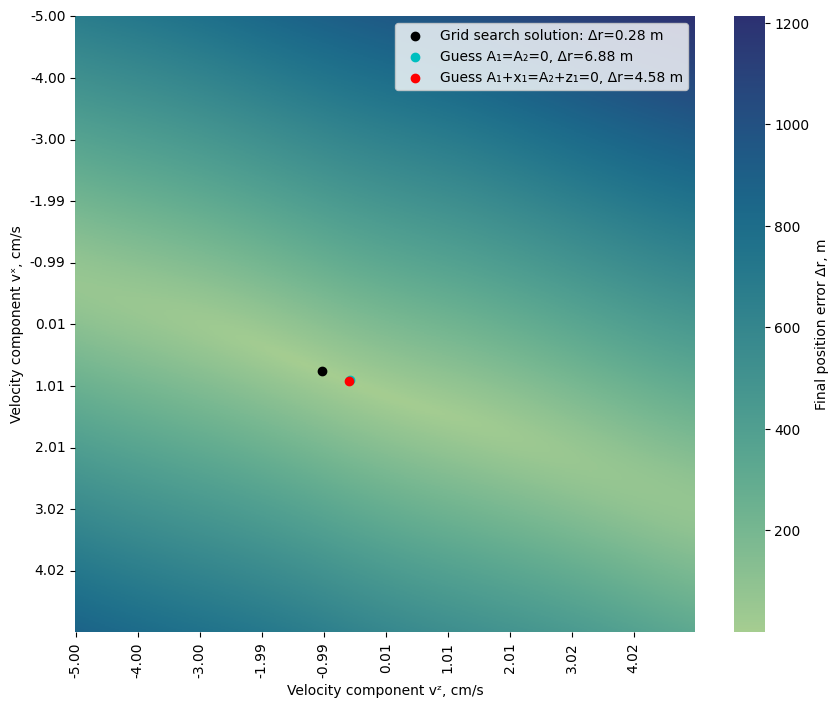

v^ORF_UB (-0) = [0.0020542027530753675, 0, -0.008933568808121222]
r^ORF_UB (-0) = [0.2857117832514291, 0, 8.082141053895754]
r^SRF_0       = [-9.161731193532482, 0, -6.339292111967159]
r^SRF_1       = [-3.350466257416061, 0, 0.4509511294984243]
r^SRF_UB (-0) = [-0.765488365195818, 0, -1.8725337077832216]
r^SRF_UB (+0) = [-0.2982040811084268, 0, -1.082879539284124]
w^ORF_UB (-0) = [0, 2.442959187116851e-05, 0]


In [355]:
r_spread = 10
v_spread = 0.01

T_max = 4000
v_max_repulsion = 0.05
m_real = 20
M_real = 650
J_y_real = 5500
J_p_y_real = 5600

N_heatmap = 100
rate = int(N_heatmap // 10)

dr_c_x, dr_c_z = var("dr_c_x dr_c_z", real=True)

def init_params(r_spread, T_max, v_max_repulsion, m_real=20, M_real=650, J_p_y_real=5600, J_y_real: float = 5500, wp_y_given: bool = False):
    vx_ub_orf_p_rand =  random.uniform(-v_spread,  v_spread)
    vz_ub_orf_p_rand =  random.uniform(-v_spread,  v_spread)
    x_ub_orf_p_rand =  random.uniform(-r_spread,     r_spread)
    z_ub_orf_p_rand =  random.uniform(-r_spread,     r_spread)
    x_ub_srf_p_rand =  random.uniform(-5,      5)
    z_ub_srf_p_rand =  random.uniform(-5,      5)
    x_ub_srf_a_rand =   x_ub_srf_p_rand + random.uniform(-1, 1)  # Центр масс меняется не очень сильно
    z_ub_srf_a_rand =   z_ub_srf_p_rand + random.uniform(-1, 1)
    x_ss_srf_p_rand =  random.uniform(-r_spread,     r_spread)
    z_ss_srf_p_rand =  random.uniform(-r_spread,     r_spread)
    x_ss_srf_a_rand =   x_ss_srf_p_rand + random.uniform(-1, 1)
    z_ss_srf_a_rand =   z_ub_srf_p_rand + random.uniform(-1, 1)
    x_target_srf_rand =  random.uniform(-r_spread,     r_spread)
    z_target_srf_rand =  random.uniform(-r_spread,     r_spread)

    rand_params = [(t, T_max), (w_0, w_hkw), (m_ss, m_real), (m_ub, M_real), (J_y, J_y_real), (Jp_y, J_p_y_real),
                   (x_ub_orf_p, x_ub_orf_p_rand), (z_ub_orf_p, z_ub_orf_p_rand), 
                   (vx_ub_orf_p, vx_ub_orf_p_rand), (vz_ub_orf_p, vz_ub_orf_p_rand),
                   (x_ub_srf_p, x_ub_srf_p_rand), (z_ub_srf_p, z_ub_srf_p_rand), 
                   (x_ub_srf_a, x_ub_srf_a_rand), (z_ub_srf_a, z_ub_srf_a_rand),
                   (x_ss_srf_p, x_ss_srf_p_rand), (z_ss_srf_p, z_ss_srf_p_rand), 
                   (x_ss_srf_a, x_ss_srf_a_rand), (z_ss_srf_a, z_ss_srf_a_rand), 
                   (x_target_srf, x_target_srf_rand), (z_target_srf, z_target_srf_rand)]
    
    phi_0_rand = random.uniform(-0.5,    -0.5)
    wp_y_rand =  random.uniform(-0.0001, 0.0001)
    rand_params += [(phi_0, phi_0_rand)]
    if not wp_y_given:
        rand_params += [(wp_y, wp_y_rand)]

    r_f_x = dr_x.subs(rand_params)
    r_f_z = dr_z.subs(rand_params)
    w_y_real = w_y.subs(rand_params)

    d_x = r_f_x - x_target_srf_rand
    d_z = r_f_z - z_target_srf_rand
    discrepansy = (d_x)**2 + (d_z)**2 
    if wp_y_given:
        func_d = lambdify([v0_x, v0_z, wp_y], discrepansy)
        func_w = lambdify([v0_x, v0_z, wp_y], w_y_real)
    else:
        func_d = lambdify([v0_x, v0_z], discrepansy)
        func_w = lambdify([v0_x, v0_z], w_y_real)

        a1 = float(a1symb.subs(rand_params))
        a2 = float(a2symb.subs(rand_params))
        a3 = float(a3symb.subs(rand_params))
        a4 = float(a4symb.subs(rand_params))
        a5 = float(a5symb.subs(rand_params))
        a6 = float(a6symb.subs(rand_params))
        b1 = float(b1symb.subs(rand_params))
        b2 = float(b2symb.subs(rand_params))
        b3 = float(b3symb.subs(rand_params))
        c1 = float(c1symb.subs(rand_params))
        c2 = float(c2symb.subs(rand_params))

    # params = (vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, Rc_x_rand, Rc_z_rand, Rx_ss_srf_a_rand, Rz_ss_srf_a_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, dr_c_x_rand, dr_c_z_rand,
    #           r_x_ss_srf_a_rand, r_z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, phi_0_rand, wp_y_rand)
    params = wp_y_rand, phi_0_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, x_ss_srf_p_rand, z_ss_srf_p_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, a1, a2, a3, a4, a5, a6, b1, b2, b3, c1, c2
    return d_x, d_z, discrepansy, func_d, func_w, params
d_x, d_z, discrepansy, func_d, func_w, params = init_params(r_spread, T_max, v_max_repulsion, m_real, M_real, J_p_y_real, J_y_real)
# vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, Rc_x_rand, Rc_z_rand, Rx_ss_srf_a_rand, Rz_ss_srf_a_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, dr_c_x_rand, dr_c_z_rand, r_x_ss_srf_a_rand, r_z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, phi_0_rand, wp_y_rand = params
wp_y_rand, phi_0_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, x_ss_srf_p_rand, z_ss_srf_p_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, a_1, a_2, a_3, a_4, a_5, a_6, b_1, b_2, b_3, c_1, c_2 = params

def draw_pair_plot(r_spread, T_max, v_max_repulsion, m_real=20, M_real=650, J_p_y_real=5600, J_y_real: float = 5500):
    # eq_tmp = Eq((c2- c1)**2, A*(c1 + c2 + A))
    # eq_v0x = solve(eq_tmp, v0_x)
    # v_x_ub_srf_a1_0 = - 2 * r_z_ss_srf_a_rand * w_hkw
    x_zeroA = (a_2*a_6 - a_3*a_5) / (a_1*a_5 - a_2*a_4)
    z_zeroA = (a_3*a_4 - a_1*a_6) / (a_1*a_5 - a_2*a_4)
    x_zeroAc = (a_2*(a_6+c_2) - a_5*(a_3+c_1)) / (a_1*a_5 - a_2*a_4)
    z_zeroAc = (a_4*(a_3+c_1) - a_1*(a_6+c_2)) / (a_1*a_5 - a_2*a_4)
    
    N_tmp = 10
    x_tmp = np.linspace(-v_max_repulsion, v_max_repulsion, N_tmp)
    
    y_zeroA1 = [(-a_2 * i - a_3) / a_1 for i in x_tmp]
    y_zeroA2 = [(-a_5 * i - a_6) / a_4 for i in x_tmp]
    
    anw = [[[0. for _ in range(N_heatmap)] for _ in range(N_heatmap)] for _ in range(2)]
    v_x_list = np.linspace(-v_max_repulsion, v_max_repulsion, N_heatmap)
    v_z_list = np.linspace(-v_max_repulsion, v_max_repulsion, N_heatmap)
    xlabels_0 = ['{:4.2f}'.format(x*100) for x in v_z_list]
    ylabels_0 = ['{:4.2f}'.format(y*100) for y in v_x_list]
    
    min_tmp_large = 1e20
    x_min = 0
    z_min = 0
    for i in range(N_heatmap):
      for j in range(N_heatmap):
          tmp = np.sqrt(func_d(v_x_list[i], v_z_list[j]))
          if tmp < min_tmp_large:
              min_tmp_large = tmp
              x_min = i
              z_min = j
          anw[0][i][j] = tmp
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # , gridspec_kw={'width_ratios': [10, 8]})
    ax = sns.heatmap(anw[0], ax=axes, cmap="crest", xticklabels=xlabels_0, yticklabels=ylabels_0, cbar_kws={'label': 'Final position error Δr, m'})
    ax.set_xticks(ax.get_xticks()[::rate])
    ax.set_xticklabels(xlabels_0[::rate])
    ax.set_yticks(ax.get_yticks()[::rate])
    ax.set_yticklabels(ylabels_0[::rate])
    # axes.set_title("a)", y=-0.17)
    axes.set_xlabel(f"Velocity component vᶻ, cm/s")
    axes.set_ylabel(f"Velocity component vˣ, cm/s")
    axes.scatter(z_min, x_min, c='k', label=f'Grid search solution: Δr={np.sqrt(func_d(v_x_list[x_min], v_z_list[z_min])):.{2}f} m')
    
    kk = N_heatmap / (2 * v_max_repulsion)
    bb = v_max_repulsion
    # axes[0].scatter((z_empirical + bb) * kk, (x_empirical + bb) * kk, c='r',  label=f'Handpicked guess solution, Δr={np.sqrt(func_d(v_x_list[int((x_empirical + bb) * kk)], v_z_list[int((z_empirical + bb) * kk)])):.{2}f} m')
    axes.scatter((z_zeroA + bb) * kk, (x_zeroA + bb) * kk, c='c',  label=f'Guess A₁=A₂=0, Δr={np.sqrt(func_d(v_x_list[int((x_zeroA + bb) * kk)], v_z_list[int((z_zeroA + bb) * kk)])):.{2}f} m')
    axes.scatter((z_zeroAc + bb) * kk, (x_zeroAc + bb) * kk, c='r',  label=f'Guess A₁+x₁=A₂+z₁=0, Δr={np.sqrt(func_d(v_x_list[int((x_zeroAc + bb) * kk)], v_z_list[int((z_zeroAc + bb) * kk)])):.{2}f} m')
    axes.legend()
    
    plt.show()
    print(f"v^ORF_UB (-0) = [{vx_ub_orf_p_rand}, 0, {vz_ub_orf_p_rand}]")
    print(f"r^ORF_UB (-0) = [{x_ub_orf_p_rand}, 0, {z_ub_orf_p_rand}]")
    print(f"r^SRF_0       = [{x_ss_srf_p_rand}, 0, {z_ss_srf_p_rand}]")
    print(f"r^SRF_1       = [{x_target_srf_rand}, 0, {z_target_srf_rand}]")
    print(f"r^SRF_UB (-0) = [{x_ub_srf_p_rand}, 0, {z_ub_srf_p_rand}]")
    print(f"r^SRF_UB (+0) = [{x_ub_srf_a_rand}, 0, {z_ub_srf_a_rand}]")
    print(f"w^ORF_UB (-0) = [0, {wp_y_rand}, 0]")
    return x_zeroA, z_zeroA, x_zeroAc, z_zeroAc, v_x_list[x_min], v_z_list[z_min]
x_zeroA, z_zeroA, x_zeroAc, z_zeroAc, x_grid, z_grid = draw_pair_plot(r_spread, T_max, v_max_repulsion, m_real, M_real, J_p_y_real, J_y_real)

### Влад, а нарисуй на картинке!

In [356]:
rand_params = [(w_0, w_hkw), (m_ss, m_real), (m_ub, M_real), (J_y, J_y_real), (Jp_y, J_p_y_real), (phi_0, phi_0_rand), (wp_y, wp_y_rand),
               (x_ub_orf_p, x_ub_orf_p_rand), (z_ub_orf_p, z_ub_orf_p_rand), 
               (vx_ub_orf_p, vx_ub_orf_p_rand), (vz_ub_orf_p, vz_ub_orf_p_rand),
               (x_ub_srf_p, x_ub_srf_p_rand), (z_ub_srf_p, z_ub_srf_p_rand), 
               (x_ub_srf_a, x_ub_srf_a_rand), (z_ub_srf_a, z_ub_srf_a_rand),
               (x_ss_srf_p, x_ss_srf_p_rand), (z_ss_srf_p, z_ss_srf_p_rand), 
               (x_ss_srf_a, x_ss_srf_a_rand), (z_ss_srf_a, z_ss_srf_a_rand), 
               (x_target_srf, x_target_srf_rand), (z_target_srf, z_target_srf_rand)]

""" В НАЧАЛЕ КОДА: МАТРИЦА ПЕРЕХОДА ОСК->ССК, А ТУТ НАДО ОБРАТНО ССК->ОСК
rg1 =  cos(phi_anw)*(r_x_anw - R_x_anw) + sin(phi_anw)*(r_z_anw - R_z_anw)
rg2 = -sin(phi_anw)*(r_x_anw - R_x_anw) + cos(phi_anw)*(r_z_anw - R_z_anw)
dis_symb = ((rg1-x_target_srf)**2 + (rg2-z_target_srf)**2)

v_ub_orf_anw = Matrix([vx_ub_orf_anw, 0, vz_ub_orf_anw])
v_ss_orf_anw = Matrix([vx_ss_orf_anw, 0, vz_ss_orf_anw])
r_ub_orf_anw = Matrix([x_ub_orf_anw, 0, z_ub_orf_anw])
r_ss_orf_anw = Matrix([x_ss_orf_anw, 0, z_ss_orf_anw])
r_target_srf = Matrix([x_target_srf, 0, z_target_srf])"""

tmp = (r_ub_orf_anw + S.T @ Matrix([x_ss_srf_a, 0, z_ss_srf_a]))
start_point_motion_x = lambdify([v0_x, v0_z, t], tmp[0].subs(rand_params))
start_point_motion_z = lambdify([v0_x, v0_z, t], tmp[2].subs(rand_params))
tmp = (r_ub_orf_anw + S.T @ r_target_srf).subs(rand_params)
targt_point_motion_x = lambdify([v0_x, v0_z, t], tmp[0].subs(rand_params))
targt_point_motion_z = lambdify([v0_x, v0_z, t], tmp[2].subs(rand_params))

# start_point_motion_x = (R_x_anw + cos(phi_anw)*(x_ss_srf_a) - sin(phi_anw)*(z_ss_srf_a)).subs(rand_params)
# start_point_motion_z = (R_z_anw + sin(phi_anw)*(x_ss_srf_a) + cos(phi_anw)*(z_ss_srf_a)).subs(rand_params)
# targt_point_motion_x = (R_x_anw + cos(phi_anw)*(x_target_srf) - sin(phi_anw)*(z_target_srf)).subs(rand_params)
# targt_point_motion_z = (R_z_anw + sin(phi_anw)*(x_target_srf) + cos(phi_anw)*(z_target_srf)).subs(rand_params)

x_7342354_tmp = lambdify([v0_x, v0_z, t], r_ss_orf_anw[0].subs(rand_params))
z_7342354_tmp = lambdify([v0_x, v0_z, t], r_ss_orf_anw[2].subs(rand_params))
UB_motion_x = lambdify([v0_x, v0_z, t], r_ub_orf_anw[0].subs(rand_params))
UB_motion_z = lambdify([v0_x, v0_z, t], r_ub_orf_anw[2].subs(rand_params))

In [367]:
def local_draw_hochy_spat(vx_, vz_, name: str, color: str, rate: int = 1, the_end: bool = False, the_start: bool = False, times: int = 200):
    vx_7342354, vz_7342354 = (vx_, vz_)
    t_list = np.linspace(T_max * 0.9 if the_end else 0, T_max * 0.1 if the_start else T_max, times)
    x_7342354 = [x_7342354_tmp(v0_x=vx_7342354, v0_z=vz_7342354, t=i) for i in t_list]
    z_7342354 = [z_7342354_tmp(v0_x=vx_7342354, v0_z=vz_7342354, t=i) for i in t_list]
    UBx_7342354 = [UB_motion_x(v0_x=vx_7342354, v0_z=vz_7342354, t=i) for i in t_list]  # Центр масс конструкции не отображается
    UBz_7342354 = [UB_motion_z(v0_x=vx_7342354, v0_z=vz_7342354, t=i) for i in t_list]
    targer_x = [targt_point_motion_x(v0_x=vx_7342354, v0_z=vz_7342354, t=i) for i in t_list]
    targer_z = [targt_point_motion_z(v0_x=vx_7342354, v0_z=vz_7342354, t=i) for i in t_list]
    plt.plot(targer_x, targer_z, ":", c=color)
    plt.plot(x_7342354, z_7342354, c=color)  #, label=f"SS trajectory ({name})")
    plt.scatter(x_7342354[-1], z_7342354[-1], c=color)
    for ii in range(int(len(t_list) // rate)):
        i = t_list[ii * rate]
        x_start = float(start_point_motion_x(v0_x=vx_7342354, v0_z=vz_7342354, t=i))
        z_start = float(start_point_motion_z(v0_x=vx_7342354, v0_z=vz_7342354, t=i))
        x_targt = float(targt_point_motion_x(v0_x=vx_7342354, v0_z=vz_7342354, t=i))
        z_targt = float(targt_point_motion_z(v0_x=vx_7342354, v0_z=vz_7342354, t=i))
        plt.plot([x_start, x_targt], [z_start, z_targt], c=color, alpha=0.2)
        plt.scatter(x_targt, z_targt, c=color, alpha=0.2)
    plt.plot([x_start, x_targt], [z_start, z_targt], c=color, alpha=1, label=f"Case: {name}")
    if the_end:
        x_ss = x_7342354_tmp(v0_x=vx_7342354, v0_z=vz_7342354, t=t_list[-1])
        z_ss = z_7342354_tmp(v0_x=vx_7342354, v0_z=vz_7342354, t=t_list[-1])
        x_tg = targt_point_motion_x(v0_x=vx_7342354, v0_z=vz_7342354, t=t_list[-1])
        z_tg = targt_point_motion_z(v0_x=vx_7342354, v0_z=vz_7342354, t=t_list[-1])
        plt.plot([x_ss, x_tg], [z_ss, z_tg], c='r')
        print(f"Ошибка положения: {np.linalg.norm([x_ss-x_tg, z_ss-z_tg])}")
    plt.xlabel("x, m")
    plt.ylabel("z, m")
    plt.legend()

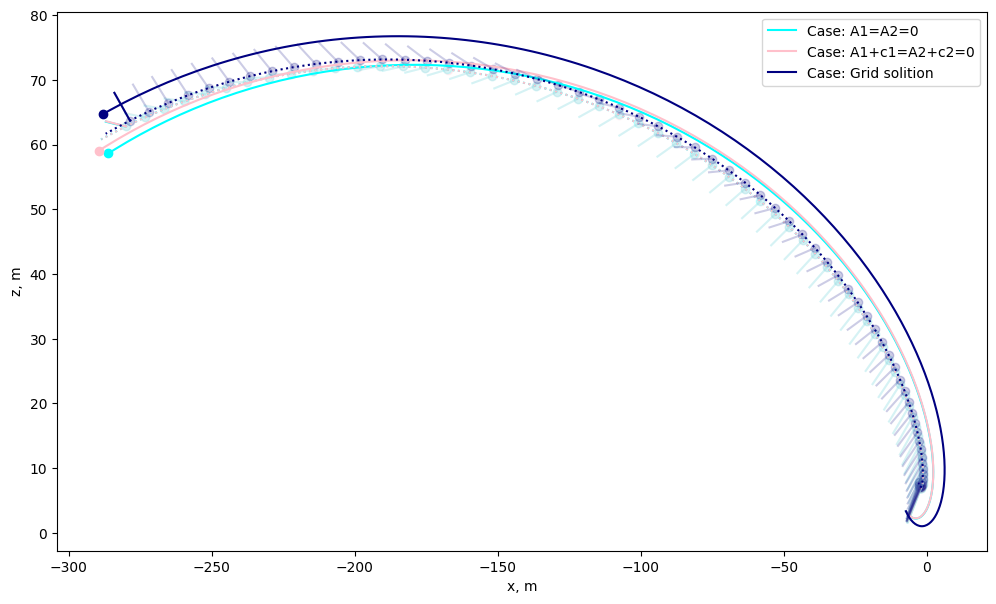

In [368]:
fig, axes = plt.subplots(figsize=(12,7))
rate = 3

local_draw_hochy_spat(x_zeroA, z_zeroA, "A1=A2=0", "cyan", rate=rate)
local_draw_hochy_spat(x_zeroAc, z_zeroAc, "A1+c1=A2+c2=0", "pink", rate=rate)
local_draw_hochy_spat(x_grid, z_grid, "Grid solition", "navy", rate=rate)

plt.show()

#### <span style="color:#2c3e50">На старте</span> 

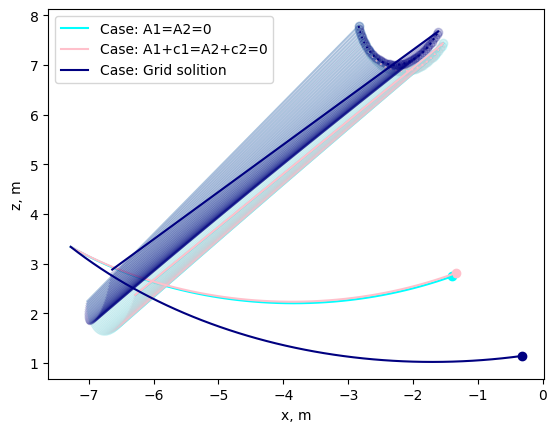

In [365]:
times = 50

local_draw_hochy_spat(x_zeroA, z_zeroA, "A1=A2=0", "cyan", the_start=True, times=times)
local_draw_hochy_spat(x_zeroAc, z_zeroAc, "A1+c1=A2+c2=0", "pink", the_start=True, times=times)
local_draw_hochy_spat(x_grid, z_grid, "Grid solition", "navy", the_start=True, times=times)

plt.show()

#### <span style="color:#2c3e50">В конце</span> 

Ошибка положения: 3.380677604161289


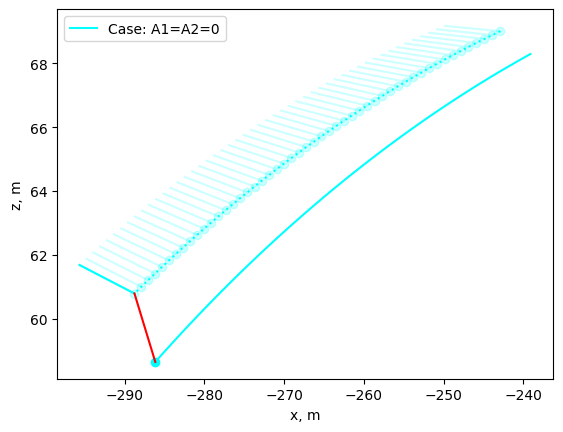

Ошибка положения: 1.8710768524427808


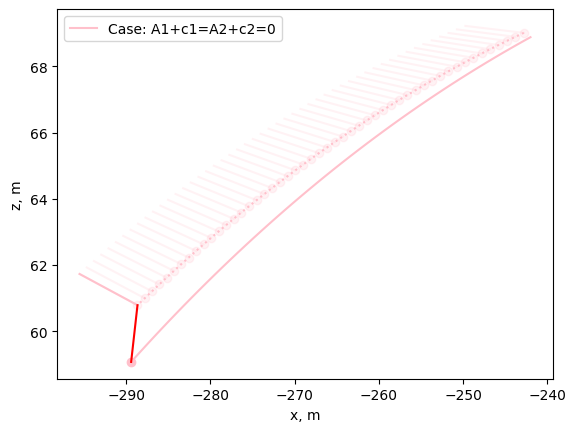

Ошибка положения: 3.1781278891198608


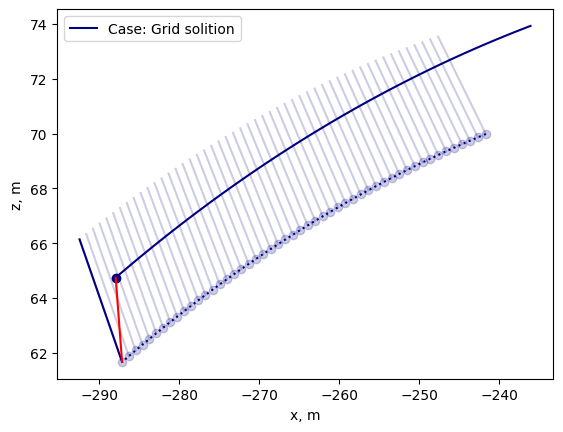

In [369]:
times = 50

local_draw_hochy_spat(x_zeroA, z_zeroA, "A1=A2=0", "cyan", the_end=True, times=times)
plt.show()
local_draw_hochy_spat(x_zeroAc, z_zeroAc, "A1+c1=A2+c2=0", "pink", the_end=True, times=times)
plt.show()
local_draw_hochy_spat(x_grid, z_grid, "Grid solition", "navy", the_end=True, times=times)
plt.show()

### <span style="color:#A254FC">Точность предположений</span> 

In [56]:
anw_dr_final_zeroA = []
anw_dr_final_zeroAc = []
anw_dv_start_zeroA = []
anw_dv_start_zeroAc = []

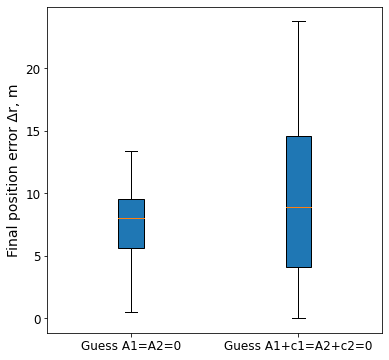

In [60]:
N_heatmap = 500
v_x_list = np.linspace(-v_max_repulsion, v_max_repulsion, N_heatmap)
v_z_list = np.linspace(-v_max_repulsion, v_max_repulsion, N_heatmap)

for _ in range(10):
    d_x, d_z, discrepansy, func_d, func_w, params = init_params(r_spread, T_max, v_max_repulsion, m_real, M_real, J_p_y_real, J_y_real)
    vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, Rc_x_rand, Rc_z_rand, Rx_ss_srf_a_rand, Rz_ss_srf_a_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, dr_c_x_rand, dr_c_z_rand, r_x_ss_srf_a_rand, r_z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, phi_0_rand, wp_y_rand, a_1, a_2, a_3, a_4, a_5, a_6, b_1, b_2, b_3, c_1, c_2 = params

    x_zeroA = (a_2*a_6 - a_3*a_5) / (a_1*a_5 - a_2*a_4)
    z_zeroA = (a_3*a_4 - a_1*a_6) / (a_1*a_5 - a_2*a_4)
    x_zeroAc = (a_2*(a_6+c_2) - a_5*(a_3+c_1)) / (a_1*a_5 - a_2*a_4)
    z_zeroAc = (a_4*(a_3+c_1) - a_1*(a_6+c_2)) / (a_1*a_5 - a_2*a_4)
    anw_dr_final_zeroA += [np.sqrt(func_d(x_zeroA, z_zeroA))]
    anw_dr_final_zeroAc += [np.sqrt(func_d(x_zeroAc, z_zeroAc))]

    min_tmp_large = 1e20
    x_min = 0
    z_min = 0
    for i in range(N_heatmap):
      for j in range(N_heatmap):
          tmp = np.sqrt(func_d(v_x_list[i], v_z_list[j]))
          if tmp < min_tmp_large:
              min_tmp_large = tmp
              x_min = i
              z_min = j
    anw_dv_start_zeroA += [np.linalg.norm([v_x_list[i] - x_zeroA, v_z_list[j] - z_zeroA])]
    anw_dv_start_zeroAc += [np.linalg.norm([v_x_list[i] - x_zeroAc, v_z_list[j] - z_zeroAc])]

labels = ['Guess A₁=A₂=0', 'Guess A₁+x₁=A₂+z₁=0']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

ax[0].boxplot([anw_dr_final_zeroA, anw_dr_final_zeroAc], vert=True, patch_artist=True,  labels=labels)
ax[0].set_ylabel("Final position error Δr, m")
ax[0].set_title("a)", y=-0.17)
ax[1].boxplot([anw_dv_start_zeroA, anw_dv_start_zeroAc], vert=True, patch_artist=True,  labels=labels)
ax[1].set_ylabel("Repulsion velocity error, m/s")
ax[1].set_title("b)", y=-0.17)

plt.show()

##### Диапазоны коэффициентов $a_i$, $b_i$

In [5]:
a_1_list = []
a_2_list = []
a_3_list = []
a_4_list = []
a_5_list = []
a_6_list = []
b_1_list = []
b_2_list = []
b_3_list = []
c_1_list = []
c_2_list = []

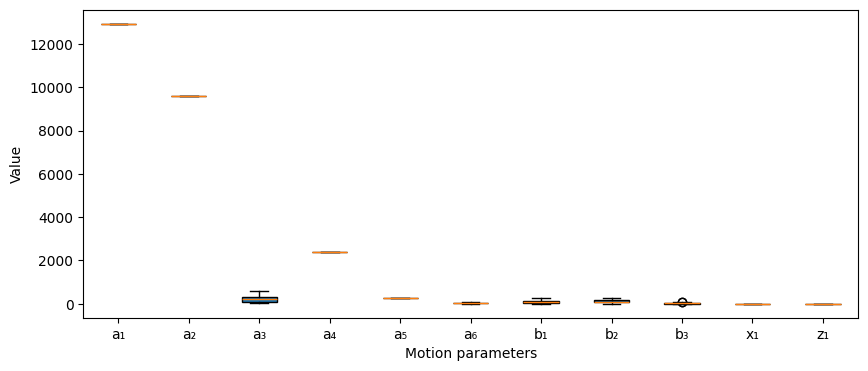

In [8]:
for _ in range(40):
    d_x, d_z, discrepansy, func_d, func_w, params = init_params(r_spread, T_max, v_max_repulsion, m_real, M_real, J_p_y_real, J_y_real)
    vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, Rc_x_rand, Rc_z_rand, Rx_ss_srf_a_rand, Rz_ss_srf_a_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, dr_c_x_rand, dr_c_z_rand, r_x_ss_srf_a_rand, r_z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, phi_0_rand, wp_y_rand, a_1, a_2, a_3, a_4, a_5, a_6, b_1, b_2, b_3, c_1, c_2 = params
    a_1_list += [abs(a_1)]
    a_2_list += [abs(a_2)]
    a_3_list += [abs(a_3)]
    a_4_list += [abs(a_4)]
    a_5_list += [abs(a_5)]
    a_6_list += [abs(a_6)]
    b_1_list += [abs(b_1)]
    b_2_list += [abs(b_2)]
    b_3_list += [abs(b_3)]
    c_1_list += [abs(c_1)]
    c_2_list += [abs(c_2)]

labels = ['a₁', 'a₂', 'a₃', 'a₄', 'a₅', 'a₆', 'b₁', 'b₂', 'b₃', 'x₁', 'z₁']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.boxplot([a_1_list, a_2_list, a_3_list, a_4_list, a_5_list, a_6_list, b_1_list, b_2_list, b_3_list, c_1_list, c_2_list], vert=True, patch_artist=True,  labels=labels)
plt.ylabel("Value")
plt.xlabel("Motion parameters")
plt.show()

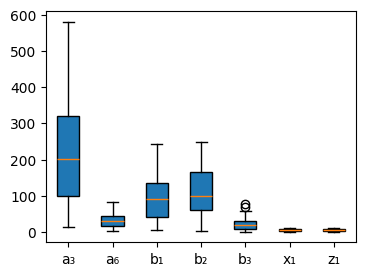

In [9]:
labels = ['a₃', 'a₆', 'b₁', 'b₂', 'b₃', 'x₁', 'z₁']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
ax.boxplot([a_3_list, a_6_list, b_1_list, b_2_list, b_3_list, c_1_list, c_2_list], vert=True, patch_artist=True,  labels=labels)
plt.show()

### <span style="color:#A254FC">Распределение при разных угловых скоростях</span> 

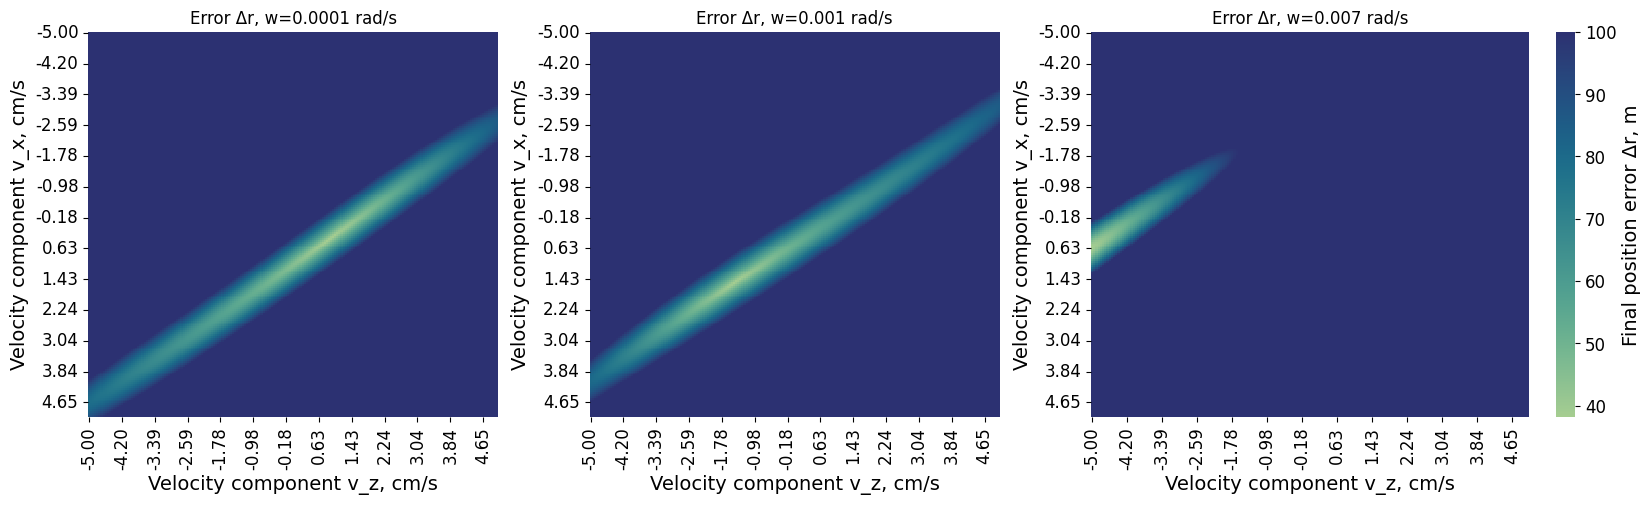

In [93]:
N_heatmap = 500
rate = 30
max_tmp_large = 100

d_x, d_z, discrepansy, func_d, func_w, params = init_params(r_spread, T_max, v_max_repulsion, m_real, M_real, J_p_y_real, J_y_real, wp_y_given=True)
def draw_multiple_heatmap_by_w(wp_y_list, figsize):
    n = len(wp_y_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, gridspec_kw={'width_ratios': [6] * (n-1) + [8]})

    for i_w in range(n):
        anw = [[0. for _ in range(N_heatmap)] for _ in range(N_heatmap)]
        v_x_list = np.linspace(-v_max_repulsion, v_max_repulsion, N_heatmap)
        v_z_list = np.linspace(-v_max_repulsion, v_max_repulsion, N_heatmap)
        xlabels_0 = ['{:4.2f}'.format(x*100) for x in v_z_list]
        ylabels_0 = ['{:4.2f}'.format(y*100) for y in v_x_list]

        min_tmp_large = 1e20
        x_min = 0
        z_min = 0
        for i in range(N_heatmap):
            for j in range(N_heatmap):
                tmp = np.sqrt(func_d(v_x_list[i], v_z_list[j], wp_y_list[i_w]))
                if tmp < min_tmp_large:
                    min_tmp_large = tmp
                    x_min = i
                    z_min = j
                anw[i][j] = tmp if tmp <= max_tmp_large else max_tmp_large

        if i_w == n-1:
            ax = sns.heatmap(anw, ax=axes[i_w], cmap="crest", xticklabels=xlabels_0, yticklabels=ylabels_0, cbar_kws={'label': 'Final position error Δr, m'})
        else:
            ax = sns.heatmap(anw, ax=axes[i_w], cmap="crest", xticklabels=xlabels_0, yticklabels=ylabels_0, cbar=False)
        ax.set_xticks(ax.get_xticks()[::rate])
        ax.set_xticklabels(xlabels_0[::rate])
        ax.set_yticks(ax.get_yticks()[::rate])
        ax.set_yticklabels(ylabels_0[::rate])
        axes[i_w].scatter(z_min, x_min, c='k', label=f'Grid search solution: Δr={np.sqrt(func_d(v_x_list[x_min], v_z_list[z_min], wp_y_list[i_w])):.{2}f} m')
        axes[i_w].set_title(f"Error Δr, w={wp_y_list[i_w]} rad/s")
        axes[i_w].set_xlabel(f"Velocity component vᶻ, cm/s")
        axes[i_w].set_ylabel(f"Velocity component vˣ, cm/s")
        axes[i_w].legend()

draw_multiple_heatmap_by_w([1e-4, 1e-3, 7e-3], (20, 5))

### <span style="color:#A254FC">Начальные приближения: оценка скорости отталкивания</span> 

##### <span style="color:#7ff388">Расчёт</span> скоростей отталкивания плоско-параллельного и статического случаев

In [33]:
r_spread = 1000
n_experiments = 100
T_max_list = [250., 500., 750., 1000., 2000., 3000., 4000., 5000., 5500., 6000., 7000.]

def get_v0(r0, r1, t):
    w = w_hkw
    x0, y0, z0 = r0
    x1, y1, z1 = r1
    den = -3 * t * w * np.sin(t * w) - 8 * np.cos(t * w) + 8
    num1 = w * (6 * t * w * z0 * np.sin(t * w) - x0 * np.sin(t * w) + x1 * np.sin(t * w) + 14 * z0 * np.cos(t * w) -
                14 * z0 - 2 * z1 * np.cos(t * w) + 2 * z1)
    num2 = w * (3 * t * w * z0 * np.cos(t * w) - 3 * t * w * z1 - 2 * x0 * np.cos(t * w) + 2 * x0 +
                2 * x1 * np.cos(t * w) - 2 * x1 - 4 * z0 * np.sin(t * w) + 4 * z1 * np.sin(t * w))
    return np.array([num1 / den,
                     w * (-y0 * np.cos(t * w) + y1)/np.sin(t * w),
                     num2 / den])

def praeter_hkw_pictura(T_max, f, r_spread, n_experiments):
    for _ in range(n_experiments):
        u = get_v0(r_spread * (2 * np.random.rand(3) - 1), r_spread * (2 * np.random.rand(3) - 1), T_max)
        f.write(f"{r_spread} {T_max} {np.linalg.norm(u)}\n")

def praeter_2d_pictura(T_max, f, r_spread, n_experiments):
    for _ in range(n_experiments):
        d_x, d_z, discrepansy, func_d, func_w, params = init_params(r_spread, T_max, v_max_repulsion, m_real, M_real, J_p_y_real, J_y_real)
        vx_ub_orf_p_rand, vz_ub_orf_p_rand, x_ub_orf_p_rand, z_ub_orf_p_rand, Rc_x_rand, Rc_z_rand, Rx_ss_srf_a_rand, Rz_ss_srf_a_rand, x_ub_srf_p_rand, z_ub_srf_p_rand, x_ub_srf_a_rand, z_ub_srf_a_rand, dr_c_x_rand, dr_c_z_rand, r_x_ss_srf_a_rand, r_z_ss_srf_a_rand, x_target_srf_rand, z_target_srf_rand, x_ss_srf_a_rand, z_ss_srf_a_rand, phi_0_rand, wp_y_rand, a_1, a_2, a_3, a_4, a_5, a_6, b_1, b_2, b_3, c_1, c_2 = params
        x_empirical = (a_2*a_6 - a_3*a_5 + a_5*np.sqrt(2*c_1**2+2*c_2**2)) / (a_1*a_5 - a_2*a_4)
        z_empirical = (a_3*a_4 - a_1*a_6 - a_4*np.sqrt(2*c_1**2+2*c_2**2)) / (a_1*a_5 - a_2*a_4)
        f.write(f"{r_spread} {T_max} {np.linalg.norm([x_empirical, 0, z_empirical])}\n")

def local_func_maker(func, name):
    f = open(name, 'a')
    p_map(func, T_max_list, [f for _ in range(len(T_max_list))], 
                            [r_spread for _ in range(len(T_max_list))], 
                            [n_experiments for _ in range(len(T_max_list))])
    f.close()

local_func_maker(praeter_hkw_pictura, f'storage/v_hkw_value_from_t_{r_spread}.txt')
local_func_maker(praeter_2d_pictura, f'storage/v_value_from_t_{r_spread}.txt')

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

##### <span style="color:#7ff388">Чтение</span> файлов, сборка данных

In [87]:
def read_files_create_dataframe(r_spread, t_max=None):
    def local_func_reader(name: str):
        dictionary = dict()
        f = open(name, 'r')
        for line in f:
            lst = line.split()
            if len(lst) > 2 and (t_max is None or t_max >= float(lst[1])):
                r = float(lst[0])
                T = float(lst[1])
                v = float(lst[2])
                if T in dictionary.keys():
                    dictionary[T] += [v * 100]
                else:
                    dictionary[T] = [v * 100]
        f.close()
        return sorted(dictionary.items())

    tmp_2d = local_func_reader(f'storage/v_value_from_t_{r_spread}.txt')
    tmp_hkw = local_func_reader(f'storage/v_hkw_value_from_t_{r_spread}.txt')
    print(f"Planar points: {[len(tmp_2d[i][1]) for i in range(len(tmp_2d))]}\nCl-W points:   {[len(tmp_hkw[i][1]) for i in range(len(tmp_hkw))]}")

    df2 = pd.DataFrame(data={'V': {}, 'Guess assumption': {}, 'Motion time, s': {}})
    for i in range(len(tmp_2d)):
        for j in range(len(tmp_2d[i][1])):
            df2 = pd.concat([df2, pd.DataFrame({'V':[tmp_hkw[i][1][j]], 'Guess assumption':['Only CW equations'], 'Motion time, s':[str(int(tmp_hkw[i][0]))]})], join="inner", ignore_index=True)
            df2 = pd.concat([df2, pd.DataFrame({'V':[tmp_2d[i][1][j]], 'Guess assumption':['Planar motion'], 'Motion time, s':[str(int(tmp_2d[i][0]))]})], join="inner", ignore_index=True)
    return df2
def draw_them_all_right_here(r_spread, reference, df2):
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(data=df2, hue='Guess assumption', x='Motion time, s', y='V')  
    left, right = plt.xlim()
    plt.hlines(reference, xmin=left, xmax=right, color='k', linestyles='--')
    plt.ylabel(f"Repulsion velocity, cm/s")
    # plt.title(f"Space structure characteristic size: r={r_spread} m. Required repulsion velocity: υ₀={reference} cm/s")
    plt.show()

##### <span style="color:#7ff388">Отображение</span> на одном графике

In [88]:
r_spread = 10
df2_10 = read_files_create_dataframe(r_spread, t_max=5000)

Planar points: [300, 300, 300, 300, 300, 300, 300, 300]
Cl-W points:   [300, 300, 300, 300, 300, 300, 300, 300]


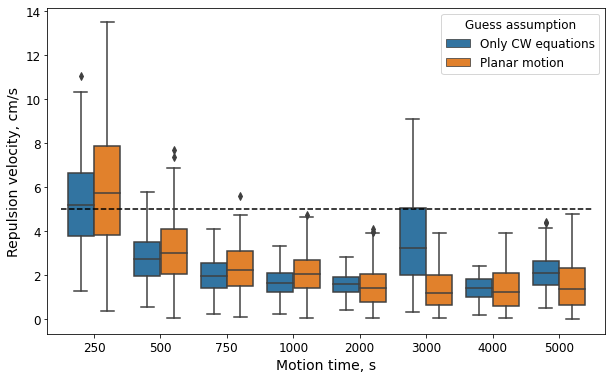

In [89]:
reference = 5
draw_them_all_right_here(r_spread, reference, df2_10)

In [90]:
r_spread = 50
df2_50 = read_files_create_dataframe(r_spread, t_max=5000)

Planar points: [100, 100, 100, 100, 100, 100, 100, 100]
Cl-W points:   [100, 100, 100, 100, 100, 100, 100, 100]


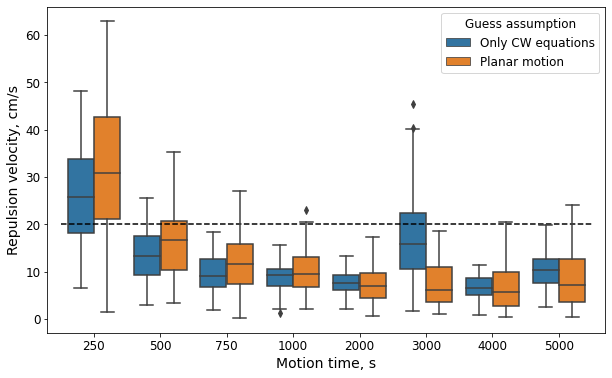

In [91]:
reference = 20
draw_them_all_right_here(r_spread, reference, df2_50)

In [35]:
r_spread = 100
df2_100 = read_files_create_dataframe(r_spread, t_max=5000)

Planar points: [100, 100, 100, 100, 100, 100, 100, 100]
Cl-W points:   [100, 100, 100, 100, 100, 100, 100, 100]


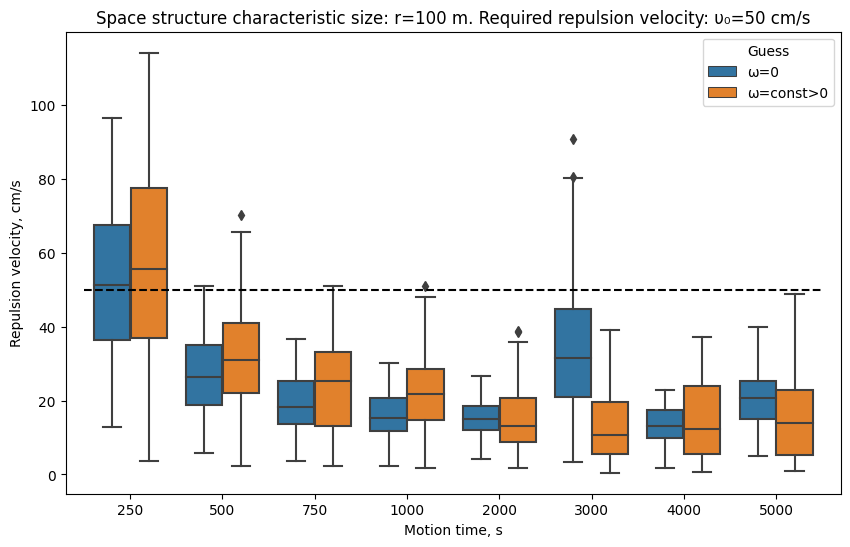

In [36]:
reference = 50
draw_them_all_right_here(r_spread, reference, df2_100)

### <span style="color:#A254FC">Heatmap g</span> 

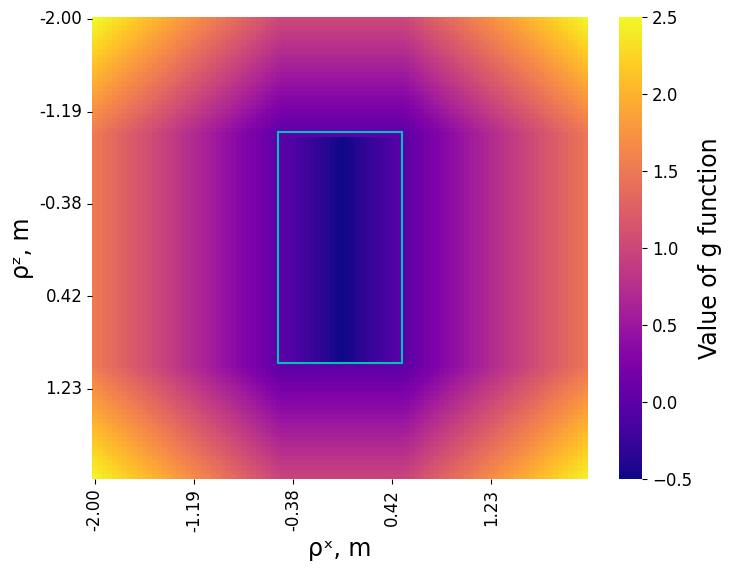

In [3]:
n_x = n_y = 100
rate = 20
x_list = np.linspace(-2, 2, n_x)
y_list = np.linspace(-2, 2, n_y)

def g(r: tuple, diam: float, l: float, reserve: float = 0, shape=False):
    # f0, f1, f2 = r

    r1 = np.array([0, 0, l])
    r2 = np.array([0, 0, -l])
    x1, y1, z1 = r1
    x2, y2, z2 = r2
    n = np.array([x2 - x1, y2 - y1, z2 - z1])  # Вектор вдоль стержня
    tau = np.cross(np.array([0, 0, 1]), n)
    if np.linalg.norm(tau) < 1e-6:
        tau = np.cross(np.array([1, 0, 0]), n)
        if np.linalg.norm(tau) < 1e-6:
            tau = np.cross(np.array([0, 1, 0]), n)
    b = np.cross(tau, n)
    a = r - (r1 + r2) / 2
    f0 = np.dot(a, n) / (np.linalg.norm(n)**2 / 2)
    f1 = np.dot(a, tau) / (np.linalg.norm(tau) * diam)
    f2 = np.dot(a, b) / (np.linalg.norm(b) * diam)
    
    if shape:
        if not ((f0 > -1) and (f0 < 1) and (f1**2 + f2**2 < 1)):
            return False
        return True
    if (f0 > -1) and (f0 < 1):
        return (np.sqrt(f1**2 + f2**2) - 1) * diam
    elif f1**2 + f2**2 < 1:
        return (abs(f0) - 1) * l
    else:
        return (np.sqrt(f1 ** 2 + f2 ** 2) - 1) * diam  + (abs(f0) - 1) * l

r = [[((i_x / n_x - 0.5) * (x_list[-1] - x_list[0]) + (x_list[-1] + x_list[0])/2, 0, (i_y / n_y - 0.5) * (y_list[-1] - y_list[0]) + (y_list[-1] + y_list[0])/2) for i_x in range(n_x)] for i_y in range(n_y)]
anw = [[g(r[i_y][i_x], diam=0.5, l=1) for i_x in range(n_x)] for i_y in range(n_y)]
# anw = [[np.linalg.norm(r[i_y][i_x]) for i_x in range(n_x)] for i_y in range(n_y)]

xlabels = ['{:4.2f}'.format(x) for x in x_list]
ylabels = ['{:4.2f}'.format(y) for y in y_list]
fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # , 
ax = sns.heatmap(anw, ax=axes, cmap="plasma", xticklabels=xlabels, yticklabels=ylabels,
                 cbar_kws={'label': 'Value of g function'}, )
ax.figure.axes[-1].yaxis.label.set_size(17)
ax.set_xticks(ax.get_xticks()[::rate])
ax.set_xticklabels(xlabels[::rate])
ax.set_yticks(ax.get_yticks()[::rate])
ax.set_yticklabels(ylabels[::rate])

def k_x(x_):
    return (x_ / (x_list[-1] - x_list[0]) + (x_list[-1] + x_list[0])/2 + 0.5) * n_x
def k_y(y_):
    return (y_ / (y_list[-1] - y_list[0]) + (y_list[-1] + y_list[0])/2 + 0.5) * n_y
ax.plot([k_x(0.5), k_x(0.5)], [k_y(1), k_y(-1)], c='c')
ax.plot([k_x(-0.5), k_x(-0.5)], [k_y(1), k_y(-1)], c='c')
ax.plot([k_x(0.5), k_x(-0.5)], [k_y(1), k_y(1)], c='c')
ax.plot([k_x(0.5), k_x(-0.5)], [k_y(-1), k_y(-1)], c='c')

axes.set_xlabel(f"ρˣ, m", fontsize=17)
axes.set_ylabel(f"ρᶻ, m", fontsize=17)
# axes.colorbar()
plt.show()

### <span style="color:#A254FC">Подбор параметров комбинированной ошибки</span> 

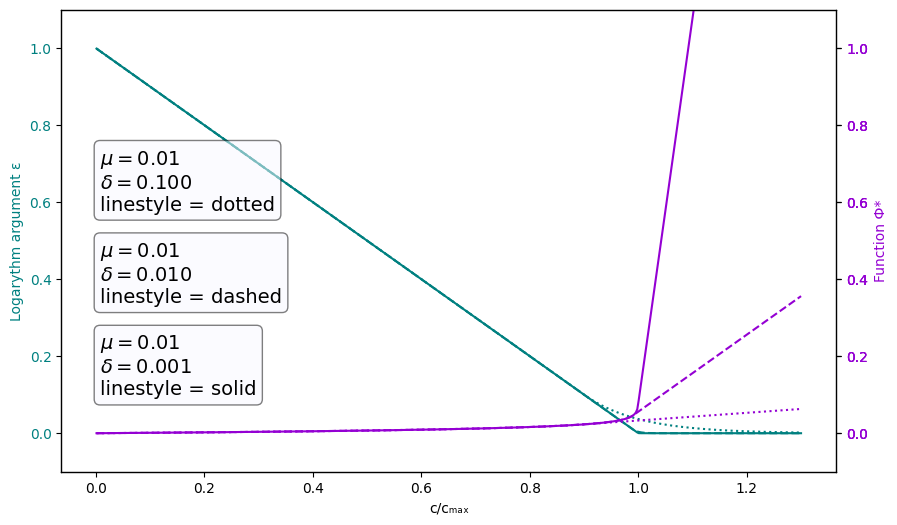

In [3]:
def e_combined(c: float, delta: float = 1e-2):
    c_max = 1.
    if c/c_max <= 1 - delta:
        e = 1 - c/c_max
    else:
        e = delta * np.exp((1 - c/c_max - delta) / delta) 
    return e

def f_combined(e: float, dr: float = 0., mu: float = 1e-2):
    return dr**2 - mu*np.log(e)
        
n = 500
mu = 1e-2

delta_list = [1e-3, 1e-2, 1e-1]
fig, axes = plt.subplots(figsize=(10,6))

color_1 = 'teal'
color_2 = 'darkviolet'
ls = ["solid", "dashed", "dotted"]
for j in range(len(delta_list)):
    c_list = np.linspace(1e-3, 1.3, n)
    e_list = [e_combined(c=c_list[i], delta=delta_list[j]) for i in range(n)]
    F_list = [f_combined(e=e_list[i], mu=mu) for i in range(n)]
    # F_list = [0 for i in range(n)]
    
    axes_twin = axes.twinx()
    axes.plot(c_list, e_list, color_1, ls=ls[j], label="ε(c)")
    axes_twin.plot(c_list, F_list, color_2, ls=ls[j], label="Ф*(c)")
    axes.set_ylabel("Logarythm argument ε", color=color_1)
    if j == 0:
        axes_twin.set_ylabel("Function Ф*", color=color_2)
    axes.tick_params(axis='y', labelcolor=color_1)
    axes_twin.tick_params(axis='y', labelcolor=color_2)
    axes.set_xlabel("c/cₘₐₓ")
    axes_twin.set_ylim([-0.1, 1.1])
    axes.set_ylim([-0.1, 1.1])
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\delta=%.3f$' % (delta_list[j], ))) + f"\nlinestyle = {ls[j]}"
    props = dict(boxstyle='round', facecolor='ghostwhite', alpha=0.5)
    axes.text(0.05, 0.3 + j/5, textstr, transform=axes.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.show()

### <span style="color:#A254FC">Исследование выполнимости задачи</span> 

##### <span style="color:#7ff388">Плоско-параллельный</span> случай

In [27]:
v0_x_approx = (a2 * a6 - a3 * a5 + a5 * sqrt(2 * c1 ** 2 + 2 * c2 ** 2)) / (a1 * a5 - a2 * a4)
v0_z_approx = (a3 * a4 - a1 * a6 + a4 * sqrt(2 * c1 ** 2 + 2 * c2 ** 2)) / (a1 * a5 - a2 * a4)
v0_x_fluminus = v0_x_approx.subs([[a1, a1symb], [a2, a2symb], [a3, a3symb], [a4, a4symb], [a5, a5symb], [a6, a6symb], 
                                  [b1, b1symb], [b2, b2symb], [b3, b3symb], [c1, c1symb], [c2, c2symb]])
v0_z_fluminus = v0_z_approx.subs([[a1, a1symb], [a2, a2symb], [a3, a3symb], [a4, a4symb], [a5, a5symb], [a6, a6symb], 
                                  [b1, b1symb], [b2, b2symb], [b3, b3symb], [c1, c1symb], [c2, c2symb]])
v0_x_max, v0_z_max = var('v0_x_max v0_z_max', real=True, constant=True)
anw_x = (v0_x_fluminus <= v0_x_max).simplify()
anw_x

v0_x_max >= M*(2*R_x_0*w_0*sin(phi_0) - R_x_0*w_0*sin(phi_0 - t*w_0)/2 - 3*R_x_0*w_0*sin(phi_0 + t*w_0)/2 - 3*R_z_0*t*w_0**2*sin(phi_0 - t*w_0)/2 + 9*R_z_0*t*w_0**2*sin(phi_0 + t*w_0)/2 - 14*R_z_0*w_0*cos(phi_0) + 5*R_z_0*w_0*cos(phi_0 - t*w_0) + 9*R_z_0*w_0*cos(phi_0 + t*w_0) - 3*Vp_z*t*w_0*cos(phi_0 - t*w_0) + 3*Vp_z*t*w_0*cos(phi_0 + t*w_0) + 16*Vp_z*sin(phi_0) - 8*Vp_z*sin(phi_0 - t*w_0) - 8*Vp_z*sin(phi_0 + t*w_0) - 2*r_x_0*w_0*sin(phi_0) + r_x_0*w_0*sin(phi_0 - t*w_0)/2 + 3*r_x_0*w_0*sin(phi_0 + t*w_0)/2 + 3*r_z_0*t*w_0**2*sin(phi_0 - t*w_0)/2 - 9*r_z_0*t*w_0**2*sin(phi_0 + t*w_0)/2 + 14*r_z_0*w_0*cos(phi_0) - 5*r_z_0*w_0*cos(phi_0 - t*w_0) - 9*r_z_0*w_0*cos(phi_0 + t*w_0) + 3*t*w_0*wp_y*x_c*cos(2*phi_0 - t*w_0)/2 - 3*t*w_0*wp_y*x_c*cos(2*phi_0 + t*w_0)/2 - 3*t*w_0*wp_y*xp_c*cos(2*phi_0 - t*w_0)/2 + 3*t*w_0*wp_y*xp_c*cos(2*phi_0 + t*w_0)/2 - 3*t*w_0*wp_y*z_0*sin(t*w_0) - 3*t*w_0*wp_y*z_c*sin(2*phi_0 - t*w_0)/2 + 3*t*w_0*wp_y*z_c*sin(2*phi_0 + t*w_0)/2 + 3*t*w_0*wp_y*zp_c*sin(t*w_

In [28]:
anw_z = (v0_z_fluminus <= v0_z_max).simplify()
anw_z

v0_z_max >= M*(sqrt(2)*w_0*sqrt(r1_x**2 + r1_z**2)*(4*cos(phi_0) - cos(phi_0 - t*w_0) - 3*cos(phi_0 + t*w_0))/2 - (4*cos(phi_0) - cos(phi_0 - t*w_0) - 3*cos(phi_0 + t*w_0))*(R_x_0*w_0 - 6*R_z_0*t*w_0**2 + 6*R_z_0*w_0*sin(t*w_0) - 4*Vp_z*cos(t*w_0) + 4*Vp_z - r_x_0*w_0 + 6*r_z_0*t*w_0**2 - 6*r_z_0*w_0*sin(t*w_0) + 3*t*w_0*wp_y*x_0*sin(phi_0) - 3*t*w_0*wp_y*x_c*sin(phi_0) + 3*t*w_0*wp_y*z_0*cos(phi_0) - 3*t*w_0*wp_y*z_c*cos(phi_0) - 4*wp_y*x_0*sin(phi_0)*sin(t*w_0) + 2*wp_y*x_0*cos(phi_0)*cos(t*w_0) - 2*wp_y*x_0*cos(phi_0) + 4*wp_y*x_c*sin(phi_0)*sin(t*w_0) + 2*wp_y*x_c*cos(phi_0)*cos(t*w_0) - 2*wp_y*x_c*cos(phi_0) - 4*wp_y*xp_c*cos(phi_0)*cos(t*w_0) + 4*wp_y*xp_c*cos(phi_0) - 2*wp_y*z_0*sin(phi_0)*cos(t*w_0) + 2*wp_y*z_0*sin(phi_0) - 4*wp_y*z_0*sin(t*w_0)*cos(phi_0) - 2*wp_y*z_c*sin(phi_0)*cos(t*w_0) + 2*wp_y*z_c*sin(phi_0) + 4*wp_y*z_c*sin(t*w_0)*cos(phi_0) + 4*wp_y*zp_c*sin(phi_0)*cos(t*w_0) - 4*wp_y*zp_c*sin(phi_0))/2 + (3*t*w_0*cos(phi_0) + 2*sin(phi_0) + sin(phi_0 - t*w_0) - 3*sin(

In [7]:
den_symb = (a1 * a5 - a2 * a4).subs([[a1, a1symb], [a2, a2symb], [a3, a3symb], [a4, a4symb], [a5, a5symb], [a6, a6symb], 
                                     [b1, b1symb], [b2, b2symb], [b3, b3symb], [c1, c1symb], [c2, c2symb]])
den_symb = den_symb.simplify()
den_symb

(M + m)**2*(3*t*w_0*sin(t*w_0) + 8*cos(t*w_0) - 8)/(M**2*w_0**2)

Когда знаменатель скоростей уходит в 0?

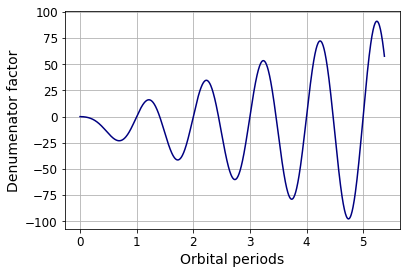

In [77]:
n_list = 1000
t_max = 3e4
t_list = np.linspace(0, t_max, n_list)
time_of_circle = 2 * np.pi / w_hkw
den_list = [3*i*w_hkw*np.sin(i*w_hkw) + 8*np.cos(i*w_hkw)-8 for i in t_list]

plt.figure(figsize=(6,4))
'''plt.plot(t_list / time_of_circle, [0 for _ in range(n_list)], c='c')
for i in range(int(t_max // time_of_circle)):
    plt.plot([(i + 1) for _ in range(2)], [np.min(den_list), np.max(den_list)], c='g')'''
plt.plot(t_list / time_of_circle, den_list, c='navy')
# plt.title(f"Denumenator dependence on time")
plt.xlabel(f"Orbital periods")
plt.ylabel(f"Denumenator factor")
plt.grid(True)
plt.show()

##### <span style="color:#7ff388">Статический</span> случай

In [ ]:
def get_v0(r0, r1, t):
    w = w_hkw
    x0, y0, z0 = r0
    x1, y1, z1 = r1
    den = -3 * t * w * np.sin(t * w) - 8 * np.cos(t * w) + 8
    num1 = w * (6 * t * w * z0 * np.sin(t * w) - x0 * np.sin(t * w) + x1 * np.sin(t * w) + 14 * z0 * np.cos(t * w) -
                14 * z0 - 2 * z1 * np.cos(t * w) + 2 * z1)
    num2 = w * (3 * t * w * z0 * np.cos(t * w) - 3 * t * w * z1 - 2 * x0 * np.cos(t * w) + 2 * x0 +
                2 * x1 * np.cos(t * w) - 2 * x1 - 4 * z0 * np.sin(t * w) + 4 * z1 * np.sin(t * w))
    return np.array([num1 / den,
                     w * (-y0 * np.cos(t * w) + y1)/np.sin(t * w),
                     num2 / den])

In [132]:
w, t = var('w t', real=True)
den = -3 * t * w * sin(t * w) - 8 * cos(t * w) + 8
den

-3*t*w*sin(t*w) - 8*cos(t*w) + 8

##### <span style="color:#e9f87f">Тот же</span> знаменатель!